# ReGraph tutorial (Neo4j backend)


## Part 1: Rewriting simple graph with attributes

This notebook consists of simple examples of usage of the ReGraph library

In [1]:
from regraph import NXGraph, Neo4jGraph, Rule
from regraph import plot_graph, plot_instance, plot_rule

In [2]:
%matplotlib inline

### 1. Creating and modifying a graph object

ReGraph implements a wrapper around the Neo4j driver, the `Neo4jGraph` class, that provides an API for accessing the underlying graph database as a graph object.

Before you can initialize a `Neo4jGraph` object, you need to start your Neo4j database. Then, you need to provide the credentials necessary to establish a connection to the instance of the Neo4j database to the constructor of `Neo4jGraph`, namely:
- URI for the _bolt_ port ('bolt://localhost:7687' in the example below)
- username ('neo4j' in the example below),
- password ('admin' in the example below).

In [7]:
# Create an empty graph object
graph = Neo4jGraph(uri="bolt://localhost:7687", user="neo4j", password="admin")

# If you run this notebooks multiple times, you need to clear the graph in the db
graph._clear()

# Add a list of nodes, optionally with attributes
graph.add_nodes_from(
    [
        'Alice',
        ('Bob', {'age': 15, 'gender': 'male'}),
        ('Jane', {'age': 40, 'gender': 'female'}),
        ('Eric', {'age': 55, 'gender': 'male'})
])

# Add a list of edges, optionally with attributes
graph.add_edges_from([
    ("Alice", "Bob"),
    ("Jane", "Bob", {"type": "parent", "since": 1993}),
    ("Eric", "Jane", {"type": "friend", "since": 1985}),
    ("Eric", "Alice", {"type": "parent", "since": 1992}),
])

In [8]:
# Print a list of nodes and edges with data attached to them
print("List of nodes: ")
for n, attrs in graph.nodes(data=True):
    print("\t", n, attrs)
print("List of edges: ")
for s, t, attrs in graph.edges(data=True):
    print("\t{}->{}".format(s, t), attrs)

List of nodes: 
	 Alice {}
	 Bob {'gender': {'male'}, 'age': {15}}
	 Jane {'gender': {'female'}, 'age': {40}}
	 Eric {'gender': {'male'}, 'age': {55}}
List of edges: 
	Alice->Bob {}
	Jane->Bob {'type': {'parent'}, 'since': {1993}}
	Eric->Alice {'type': {'parent'}, 'since': {1992}}
	Eric->Jane {'type': {'friend'}, 'since': {1985}}


In [9]:
# Add individual nodes and edges
graph.add_node('Sandra', {'age': 45, 'gender': 'female'})

graph.add_edge("Sandra", "Eric", {"type": "spouse", "since": 1990})
graph.add_edge("Eric", "Sandra", {"type": "spouse", "since": 1990})
graph.add_edge("Sandra", "Alice", {"type": "parent", "since": 1992})

In [10]:
# Add node and edge attributes
graph.add_node_attrs("Alice", {"age": 18, "gender": "female"})
graph.add_edge_attrs("Alice", "Bob", {"type": "friend", "since": 2004})

# Get attributes of nodes and edges 
print("New Alice attibutes: ", graph.get_node("Alice"))
print("New Alice->Bob attributes: ", graph.get_edge("Alice", "Bob"))

New Alice attibutes:  {'gender': {'female'}, 'age': {18}}
New Alice->Bob attributes:  {'type': {'friend'}, 'since': {2004}}


Note that the attributes of the nodes/edges are converted to `regraph.attribute_sets.FiniteSet` objects. See the tutorial on advanced attribute values (`Tutorial_advanced_attributes.ipynb`) for more details on the underlying data structures.

In [11]:
for k, v in graph.get_node("Alice").items():
    print(k, ": ", v, ", type: ", type(v))

gender :  {'female'} , type:  <class 'regraph.attribute_sets.FiniteSet'>
age :  {18} , type:  <class 'regraph.attribute_sets.FiniteSet'>


Graph objects can me dumped to dictionaries following the JSON format (note how the attribute values are encoded).

In [12]:
graph.to_json()

{'edges': [{'from': 'Alice',
   'to': 'Bob',
   'attrs': {'type': {'type': 'FiniteSet', 'data': ['friend']},
    'since': {'type': 'FiniteSet', 'data': [2004]}}},
  {'from': 'Jane',
   'to': 'Bob',
   'attrs': {'type': {'type': 'FiniteSet', 'data': ['parent']},
    'since': {'type': 'FiniteSet', 'data': [1993]}}},
  {'from': 'Eric',
   'to': 'Sandra',
   'attrs': {'type': {'type': 'FiniteSet', 'data': ['spouse']},
    'since': {'type': 'FiniteSet', 'data': [1990]}}},
  {'from': 'Eric',
   'to': 'Alice',
   'attrs': {'type': {'type': 'FiniteSet', 'data': ['parent']},
    'since': {'type': 'FiniteSet', 'data': [1992]}}},
  {'from': 'Eric',
   'to': 'Jane',
   'attrs': {'type': {'type': 'FiniteSet', 'data': ['friend']},
    'since': {'type': 'FiniteSet', 'data': [1985]}}},
  {'from': 'Sandra',
   'to': 'Alice',
   'attrs': {'type': {'type': 'FiniteSet', 'data': ['parent']},
    'since': {'type': 'FiniteSet', 'data': [1992]}}},
  {'from': 'Sandra',
   'to': 'Eric',
   'attrs': {'type': {'t

### 2. Finding graph patterns

In [13]:
# Initialize a pattern graph as NXGraph object

pattern = NXGraph()
pattern.add_nodes_from(["x", "y", "z"])
pattern.add_edges_from([
    ("x", "y"),
    ("z", "y")
])

# Find matchings of the pattern in the graph
instances = graph.find_matching(pattern)
print(instances)

[{'x': 'Jane', 'y': 'Bob', 'z': 'Alice'}, {'x': 'Alice', 'y': 'Bob', 'z': 'Jane'}, {'x': 'Sandra', 'y': 'Alice', 'z': 'Eric'}, {'x': 'Eric', 'y': 'Alice', 'z': 'Sandra'}]


We can equip pattern nodes and edges with attributes, then ReGraph will look for all subgraphs matching to the structure of the pattern _and_ whose elements contain respective attributes.

In [14]:
pattern.add_edge_attrs("x", "y", {"type": "parent"})
pattern.add_edge_attrs("z", "y", {"type": "parent"})

instances = graph.find_matching(pattern)
print(instances)

[{'x': 'Jane', 'y': 'Bob', 'z': 'Alice'}, {'x': 'Alice', 'y': 'Bob', 'z': 'Jane'}, {'x': 'Sandra', 'y': 'Alice', 'z': 'Eric'}, {'x': 'Eric', 'y': 'Alice', 'z': 'Sandra'}]


### 3. Rewriting graph objects

ReGraph implements the rewriting technique called _Sesqui-pushout rewriting_ that allows to transform graphs by applying _rules_ through their instances (matchings). It allows to express the following graph transformations:

- node cloning,
- node/edge removal,
- node/edge attributes removal,
- node merging,
- node/edge addition,
- node/edge attribute addition.

A rewriting rule is a span $LHS \leftarrow P \rightarrow RHS$, where $LHS$ is a graph that represents a left-hand side of the rule -- a pattern that is going to be matched inside of the input graph, $P$ is a graph that represents the interfaces of the rule -- together with a homomorphism $LHS \leftarrow P$ it specifies nodes and edges that are going to be preserved in the course of application of the rule. $RHS$ and a homomorphism $P \rightarrow RHS$, on the other hand, specify nodes and edges that are going to be added. In addition, if two nodes $n^P_1, n^P_2$ of $P$ map to the same node $n^{LHS}$ in $LHS$, $n^{LHS}$ is going to be cloned during graph rewriting. Symmetrically, if two nodes of $n^P_1$ and $n^P_2$ in $P$ match to the same node $n^{RHS}$ in $RHS$, $n^P_1$ and $n^P_2$ are merged.


To rewrite the graph, we first create a rewriting rule (see `Tutorial_rules.ipynb` on more examples of rules and means for their creation provided by ReGraph). A data structure for rewriting rules is implemeted in the class `regraph.rules.Rule`. Here, we will use the created pattern to initialize a rule. ReGraph implements the util `plot_rule` ror rule visualization.

/home/eugenia/anaconda3/envs/kami/lib/python3.7/site-packages/matplotlib-3.0.3-py3.7-linux-x86_64.egg/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


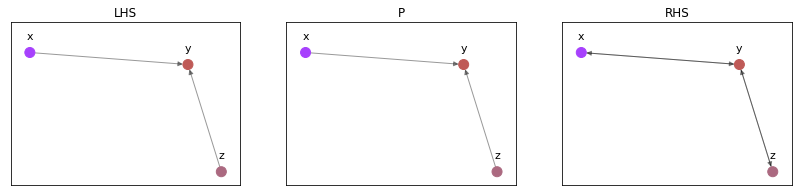

In [15]:
rule = Rule.from_transform(pattern)
rule.inject_add_edge("y", "x", {"type": "child_of"})
rule.inject_add_edge("y", "z", {"type": "child_of"})

plot_rule(rule)

Graph rewriting can be performed with the `rewrite` method of `NXGraph`. It takes as an input a rule and an instance of this rule. Rewriting is performed in-place, the provided graph object is modified and a dictionary corresponding to the $RHS$ matching in the rewritten graph ($RHS \rightarrowtail G'$) is returned.

In [16]:
# Rewrite using the first instances
rhs_graph = graph.rewrite(rule, instances[0])
print(rhs_graph)

{'x': 'Jane', 'y': 'Bob', 'z': 'Alice'}


Let us consider another example of a rewriting rule

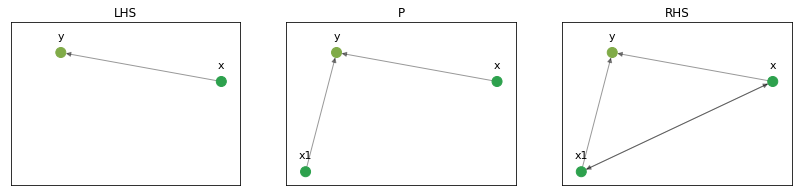

In [17]:
# Create a pattern
pattern = NXGraph()
pattern.add_nodes_from(["x", "y"])
pattern.add_edge("x", "y", {"type": "parent"})

# Initialize a rule that clones `x`, note that tha variable `rhs_clone_id`
# corresponds to the ID of the newly produced clone in the RHS of the rule
rule = Rule.from_transform(pattern)
_, rhs_clone_id = rule.inject_clone_node("x")
rule.inject_add_edge("x", rhs_clone_id, {"type": "spouse"})
rule.inject_add_edge(rhs_clone_id, "x", {"type": "spouse"})

plot_rule(rule)

In [18]:
# Find matching in the graph
instances = graph.find_matching(rule.lhs)
print(instances)

[{'x': 'Alice', 'y': 'Bob'}, {'x': 'Bob', 'y': 'Jane'}, {'x': 'Bob', 'y': 'Alice'}, {'x': 'Jane', 'y': 'Bob'}, {'x': 'Eric', 'y': 'Sandra'}, {'x': 'Eric', 'y': 'Alice'}, {'x': 'Eric', 'y': 'Jane'}, {'x': 'Sandra', 'y': 'Alice'}, {'x': 'Sandra', 'y': 'Eric'}]


In [19]:
# Let us fix an instace
instance = {'x': 'Jane', 'y': 'Bob'}

In [20]:
rhs_graph = graph.rewrite(rule, instance)

In [22]:
print(rhs_graph)

{'x': 'Jane1', 'y': 'Bob', 'x1': 'Jane'}
